<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-up</a></span><ul class="toc-item"><li><span><a href="#Import-Standard-Packages" data-toc-modified-id="Import-Standard-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Standard Packages</a></span></li><li><span><a href="#Import-Symawofo-Packages" data-toc-modified-id="Import-Symawofo-Packages-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import Symawofo Packages</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Add-Additional-Features" data-toc-modified-id="Add-Additional-Features-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Add Additional Features</a></span></li></ul></li><li><span><a href="#Construct-Base-Model-and-other-Functions" data-toc-modified-id="Construct-Base-Model-and-other-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construct Base Model and other Functions</a></span></li><li><span><a href="#Individual-Substrat-Performance" data-toc-modified-id="Individual-Substrat-Performance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Individual Substrat Performance</a></span><ul class="toc-item"><li><span><a href="#Substrat-PL" data-toc-modified-id="Substrat-PL-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Substrat PL</a></span></li><li><span><a href="#Substrat-Performance-Result" data-toc-modified-id="Substrat-Performance-Result-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Substrat Performance Result</a></span></li><li><span><a href="#Threshold-Viewer" data-toc-modified-id="Threshold-Viewer-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Threshold Viewer</a></span></li></ul></li><li><span><a href="#Substrat-Weighting" data-toc-modified-id="Substrat-Weighting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Substrat Weighting</a></span><ul class="toc-item"><li><span><a href="#Substrat-Correlations" data-toc-modified-id="Substrat-Correlations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Substrat Correlations</a></span></li><li><span><a href="#Dendograms" data-toc-modified-id="Dendograms-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Dendograms</a></span></li><li><span><a href="#Weighted-Substrat-Performance" data-toc-modified-id="Weighted-Substrat-Performance-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Weighted Substrat Performance</a></span></li><li><span><a href="#Strat-Table-Results" data-toc-modified-id="Strat-Table-Results-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Strat Table Results</a></span></li><li><span><a href="#Equal-Variance-PL-Charts" data-toc-modified-id="Equal-Variance-PL-Charts-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Equal Variance PL Charts</a></span></li><li><span><a href="#Substrat-Weighting-Charts" data-toc-modified-id="Substrat-Weighting-Charts-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Substrat Weighting Charts</a></span></li><li><span><a href="#Effective-Weights" data-toc-modified-id="Effective-Weights-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Effective Weights</a></span></li></ul></li><li><span><a href="#Feature-Correlations" data-toc-modified-id="Feature-Correlations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Correlations</a></span></li></ul></div>

# Set-up

## Import Standard Packages

In [1]:
# %load_ext autoreload 
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import json

from pathlib import Path
from copy import deepcopy
from datetime import datetime
from tqdm.auto import tqdm
from dask import delayed, compute
from itertools import starmap
from functools import reduce, wraps
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import pairwise_distances, matthews_corrcoef, euclidean_distances
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import AgglomerativeClustering
from sklearn import set_config
set_config(display='diagram')

from ipywidgets import widgets

# internal
import sys
sys.path.append(r"/home/osindi/ami")
sys.path.append(r"/home/osindi/Symawofo")
sys.path.append(r"C:\SyMAWoFlo\Symawofo")
sys.path.append(r"C:\ami")

## Import Symawofo Packages

In [2]:
from symawofo import make_pipeline, WindowFrame, DataSplitter, FeatureFrame, FeatureSeries
from symawofo.transformers import Lag, Difference, StandardScaler, TransformedTargetRegressor, Clipper, WinsorClipper
from symawofo.transformers.compose import ColumnTransformer, make_column_transformer
from symawofo.models.base import model as model_dec, RegressorMixin2d, BaseModel
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.ensemble.voting import make_voting_regressor, VotingRegressor

from ami.build.common import quick_pnl
from ami.sse.jobspec import SSEJobspec
from macro_utils import MACROBOT_PATH, load_datastore



In [3]:
from symawofo import get_client
client = get_client('local')

/home/osindi/env/symawofo2/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46339 instead
  warnings.warn(


In [4]:
# pt = Path(r'/mnt/macrobot/data/Transformed_Data.csv')
# t =pd.read_csv(pt)
# # list(pt.iterdir())

## Load Data

In [5]:
def get_two_layer_var_group(meta):
    var_group = defaultdict(lambda :defaultdict(set))
    meta['Tags'] = meta['Tags'].fillna('')
    meta['Country'] = meta['Country'].fillna('')
    for idx,row in meta.iterrows():
        country = row.Country
        for t in row.Tags.split(';'):
            var_group[country][t].add(idx)
    return var_group


def get_epfr():
    epfr_sheet = MACROBOT_PATH / 'data' / 'EPFR/epfr_master.csv'
    epfr_master = pd.read_csv(epfr_sheet, index_col=0)
    epfr_master.index = pd.to_datetime(epfr_master.index)
    epfr_master_lag = epfr_master.shift(2)
    epfr_master_lag = epfr_master_lag[[i for i in epfr_master_lag.columns if 'weeklyUS' in i]]
    epfr_master_lag = epfr_master_lag.fillna(method='ffill', limit=5)
    return epfr_master_lag['FX-weeklyUSD']


# CUTOFF_DATE
df_master, meta, _ = load_datastore(cutoff_date=datetime(2006, 1, 1), dont_drop=['US_FOMC_Nairu'])
var_group = get_two_layer_var_group(meta)
# REMEMBER TO COMMENT OUT IF YOU WANT EPFR AND EPFR2 SERIES
# exclude_epfr = meta.query('Source != "EPFR" & Source != "EPFR2"').index
# df_master =df_master[exclude_epfr]

# custom series
a = df_master['US_CBO_Nairu'].loc[df_master.index<=datetime(2009,2,1)].copy()
b = df_master['US_FOMC_Nairu'].copy().dropna()
df_master['US_Nairu_CBO_FOMC_blend'] = pd.concat([a, b], axis=0)
df_master['US_Equity_Real_Vol1m'] = np.exp(df_master['US_Equity_Fut']).pct_change().rolling(21).std()*np.sqrt(252)
df_master['EMU_Equity_Vol_S1'] = df_master['EMU_Equity_Vol'].shift(1)
df_master['EMU_Bond_2y_S1'] = df_master['EMU_Bond_2y'].shift(1)

eq_ctry2_Armenia             2020-12-17 13:31:53.851471
eq_ctry2_Suriname            2020-12-17 13:31:53.850673
eq_ctry2_Yemen               2020-12-17 13:31:53.847769
eq_ctry2_TrinidadandTobago   2020-12-17 13:31:53.834740
eq_ctry2_Tajikistan          2020-12-17 13:31:53.831609
                                        ...            
bond_ctry2_Kenya             2006-01-27 00:00:00.000000
bond_ctry2_Iran              2006-01-27 00:00:00.000000
bond_ctry2_Cyprus            2006-01-27 00:00:00.000000
JPY_CBEI_I_raw               2006-01-25 00:00:00.000000
JPY_CBEI_G_raw               2006-01-25 00:00:00.000000
Length: 360, dtype: datetime64[ns]


In [6]:
df_master_weekly = df_master.resample('W-Fri').last()

## Add Additional Features

In [7]:
def zscore(x, w=10):
    return (x-x.rolling(w).mean())/x.rolling(w).std()

df_master_weekly['US_Equity_Fut_ChgP'] = np.exp(df_master_weekly['US_Equity_Fut']).pct_change()
df_master_weekly['US_Equity_Vol_Chg'] = df_master_weekly['US_Equity_Vol'].diff()
df_master_weekly['Mom_Change_SPX'] = np.exp(df_master_weekly['US_Equity']).pct_change(4)*52/4 - np.exp(df_master_weekly['US_Equity']).pct_change(52)
df_master_weekly['DXY_ChgP'] = np.exp(df_master_weekly['DXY']).pct_change()
df_master_weekly['SPGSIN_Chg13'] = df_master_weekly['GLOB_Ind_metals'].diff(13)
df_master_weekly['eq_per_flows_USA'] = df_master_weekly['eq_per_flows_USA']
df_master_weekly['US_Equity_Real_Vol1m_Chg'] = df_master_weekly['US_Equity_Real_Vol1m'].diff()
df_master_weekly['US_Lois3m_Chg'] = df_master_weekly['US_Lois3m'].diff()
df_master_weekly['US_2y_v_OIS_ZSc52'] = zscore(df_master_weekly['US_2y_v_OIS'], 52)
df_master_weekly['US_Bond_30y_ZSc52'] = zscore(df_master_weekly['US_Bond_30y'], 52)
df_master_weekly['US_10y_2y_ZSc52'] = zscore((df_master_weekly['US_Bond_10y']-df_master_weekly['US_Bond_2y']), 52)
df_master_weekly['GLOB_EM_HCSp_Chg'] = df_master_weekly['GLOB_EM_HCSp'].diff()

In [8]:
df_master_weekly['IT_GE_Sp2y_Chg'] = (df_master_weekly['IT_Bond_2y']-df_master_weekly['GE_Bond_2y']).diff()
df_master_weekly['EMU_Equity_Fut_ChgP'] = np.exp(df_master_weekly['EMU_Equity_Fut']).pct_change()
df_master_weekly['EMU_Equity_Vol_Chg'] = df_master_weekly['EMU_Equity_Vol'].diff()
df_master_weekly['EMU_Equity_Vol_S1_Chg'] = df_master_weekly['EMU_Equity_Vol_S1'].diff()
df_master_weekly['EMU_10y_2y_ZSc52'] = zscore(df_master_weekly['EMU_Bond_10y']-df_master_weekly['EMU_Bond_2y'], 52)
df_master_weekly['EMU_Bond_30y_ZSc52'] = zscore(df_master_weekly['EMU_Bond_30y'], 52)
df_master_weekly['EMU_Bond_2y_ZSc13'] = zscore(df_master_weekly['EMU_Bond_2y'], 13)
df_master_weekly['EMU_Bond_2y_S1_ZSc13'] = zscore(df_master_weekly['EMU_Bond_2y_S1'], 13)


In [147]:
df_master_weekly['US_Bond_30y_Fut_ChgP'] = np.exp(df_master_weekly['US_Bond_30y_Fut']).pct_change()
df_master_weekly['US_2y_v_OIS_Chg'] = df_master_weekly['US_2y_v_OIS'].diff()
df_master_weekly['US_10y_2y_Chg'] = (df_master_weekly['US_Bond_10y']-df_master_weekly['US_Bond_2y']).diff()
df_master_weekly['US_30y_10y_Chg'] = (df_master_weekly['US_Bond_30y']-df_master_weekly['US_Bond_10y']).diff()
df_master_weekly['GLOB_Oil_Chg6'] = np.exp(df_master_weekly['GLOB_Oil']).pct_change(6)
df_master_weekly['US_Breakeven1_Chg9'] = df_master_weekly['US_Breakeven1'].diff(9)


In [200]:
df_master_weekly['SPGSIN_Chg'] = df_master_weekly['GLOB_Ind_metals'].diff()
us_aud_eq3m = np.exp(df_master['US_Equity_Fut']).pct_change(63)-np.exp(df_master['AUD_Equity_Fut']).pct_change(63)
df_master_weekly['US_AUD_Eq3m_S1'] = us_aud_eq3m.shift(1).resample('W-Fri').last()

In [ ]:
# [('FX_AUD_Daily_Carry_Ann_lag', '0', 'larger', '1'),
#  ('FX_AUD_Daily_Carry_Ann_lag', '0', 'smaller', '-1'),
#  ('GLOB_Ind_metals_Chg13_lag', '0.0', 'larger', '1'),
#  ('GLOB_Ind_metals_Chg13_lag', '-0.0', 'smaller', '-1'),
#  ('GLOB_Ind_metals_lagpchg', '0', 'larger', '1'),
#  ('GLOB_Ind_metals_lagpchg', '0', 'smaller', '-1'),
#  ('AUD_Trade_Bal_lag', '0', 'larger', '1'),
#  ('AUD_Trade_Bal_lag', '0', 'smaller', '-1'),
 ('US_AUD_Eq3m_lag', '0', 'larger', '-1'),
 ('US_AUD_Eq3m_lag', '0', 'smaller', '1'),
#  ('CFTC_AUD_NonComm_NOI_lag', '0', 'larger', '1'),
#  ('CFTC_AUD_NonComm_NOI_lag', '0', 'smaller', '-1'),
#  ('US_2y_v_OIS_ZSc52_lag', '0', 'larger', '-1'),
#  ('US_2y_v_OIS_ZSc52_lag', '0', 'smaller', '1')]

In [9]:
data = df_master_weekly

# Construct Base Model and other Functions

In [10]:
import pandas as pd
from copy import deepcopy
from symawofo import make_pipeline, WindowFrame, FeatureFrame, FeatureSeries
from symawofo.transformers import StandardScaler, TransformedTargetRegressor, WinsorClipper
from symawofo.transformers.compose import make_column_transformer
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.pnl import PNL, AssetType
from symawofo.ensemble.voting import make_voting_regressor
from ami.sse.models import SubStrat
from ami.build.common import make_data_splitter, make_preprocessing


def make_model(param_grid, scoring_func, dynamic_threshold=None, _name=None):
    return SubStrat(lags=0,
                    param_grid=param_grid,
                    scorer=scoring_func,
                    dynamic_threshold=dynamic_threshold,
                    _name=_name)


def build_voting_regressor(substrat_meta_list, df):
    estimators = []
    features = []
    for meta in substrat_meta_list:
        feature_name = meta['feature_name']
        feature_preprocessing = meta['feature_preprocessing']

        model_params = dict(param_grid=meta['param_grid'],
                            scoring_func=meta['scoring_func'],
                            dynamic_threshold=meta.get('dynamic_threshold', None),
                            _name=feature_name)

        feature = df[feature_name].copy().dropna()
        pick_out_col = make_column_transformer(('passthrough', feature_name), remainder='drop')

        if feature_preprocessing is not None:
            estimator = deepcopy(feature_preprocessing)
            estimator.steps.insert(0, (feature_name, pick_out_col))
            estimator.steps.append(('model', make_model(**model_params)))
        else:
            estimator = make_model(**model_params)
            estimator = make_pipeline(pick_out_col, estimator)
        features.append(feature)

        estimators.append(estimator)
    vregr = make_voting_regressor(*estimators, agg_fn=None, n_jobs=None)
    features = FeatureFrame(pd.concat(features, axis=1).dropna())
    return vregr, features


def get_target_estimator(estimator, percentile):
    target_transformer = WinsorClipper(left_prob=percentile, right_prob=1 - percentile)
    target_estimator = TransformedTargetRegressor(estimator, target_transformer)
    return target_estimator


def build_window_frame(jobspec, data):
    estimator, features = build_voting_regressor(jobspec['substrats'], data)
    target = data[jobspec.target.name]
    modelling_target = make_preprocessing(FeatureSeries(target), jobspec.target.prediction_lag)
    splitter = make_data_splitter(jobspec)
    if percentile:= jobspec.target.get('winsorclipper'):
        estimator = get_target_estimator(estimator, percentile)

    wf = WindowFrame(
        features=features,
        target=modelling_target,
        splitter=splitter,
        estimator=estimator,
        n_jobs=-1,
        parallel_backend='dask'
    )
    return wf


def main(spec, data):
    wf = build_window_frame(spec, data)
    signal = ThresholdSignSignal(wf, threshold=0)
    pnl = PNL(signal, asset_type=AssetType(log=True, level=False), **spec.trade)
    pnl.get_pnl()
    return pnl





In [202]:
string_spec = {
  "target": {
    "name": "FX_AUD_TR",
    "prediction_lag": 1,
    "winsorclipper": 0
  },
  "substrats": [

     {"feature_name": "FX_AUD_Daily_Carry_Ann",
     "param_grid": {"func": "[short_mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"},
      
     {"feature_name": "SPGSIN_Chg13",
     "param_grid": {"func": "[short_mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"},
      
     {"feature_name": "SPGSIN_Chg",
     "param_grid": {"func": "[short_mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"},
      
     {"feature_name": "AUD_Trade_Bal",
     "param_grid": {"func": "[short_mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"},
      
     {"feature_name": "US_2y_v_OIS_ZSc52",
     "param_grid": {"func": "[mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"},
      
     {"feature_name": "CFTC_AUD_NonComm_NOI",
     "param_grid": {"func": "[short_mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"},
      
     {"feature_name": "US_AUD_Eq3m_S1",
     "param_grid": {"func": "[mixed]", "thresh": [0]},
     "feature_preprocessing": None,
     "scoring_func": "active_mean_reg_score"}
     
],
  "data_splitter": {
    "expanding": 1,
    "test_size": 13,
    "initial_training_size": 104
  },
  "trade": {
    "t_cost": 0.0001
  },
  "clustering":{
      "is_signal": True,
      "corr": "euclidean_distances"
  }
}

In [203]:
path = Path(r"/home/osindi/ami")
asset = 'EMU_Equity_Fut_Fixed'
file = path /'ami' /'sse' /'job_spec' / f'{asset}.json'
# string_spec = SSEJobspec(json.loads(file.read_bytes())) #comment this to use spec in cell above
string_spec = SSEJobspec(string_spec) #Use spec in cell above
spec = string_spec.convert_jobspec_from_json()
pnl = main(spec, data)

Monitor progress at http://10.27.2.239:46339/status
Monitor progress at http://10.27.2.239:46339/status


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


# Individual Substrat Performance

## Substrat PL

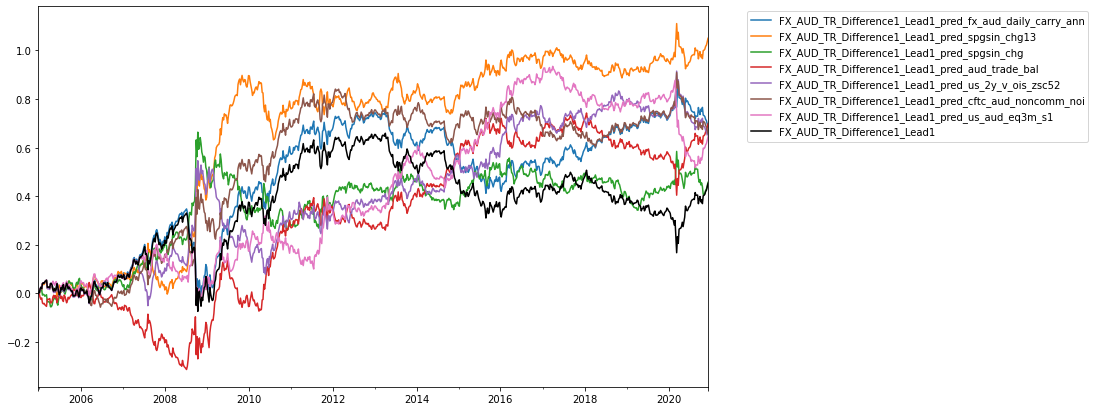

In [205]:
from ami.sse.charting_tools import *
plot_substrats(pnl)

## Substrat Performance Result

In [206]:
view_substrats_table(pnl)

Average_Signal  Long  \
FX_AUD_TR_Difference1_Lead1_pred_fx_aud_daily_c...            0.66  0.83   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg13                 0.09  0.54   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg                   0.01  0.50   
FX_AUD_TR_Difference1_Lead1_pred_aud_trade_bal               -0.21  0.40   
FX_AUD_TR_Difference1_Lead1_pred_us_2y_v_ois_zsc52            0.09  0.54   
FX_AUD_TR_Difference1_Lead1_pred_cftc_aud_nonco...            0.28  0.64   
FX_AUD_TR_Difference1_Lead1_pred_us_aud_eq3m_s1              -0.16  0.42   
Target                                                        1.00  1.00   

                                                    Flat  Short  \
FX_AUD_TR_Difference1_Lead1_pred_fx_aud_daily_c...   0.0   0.17   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg13        0.0   0.46   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg          0.0   0.50   
FX_AUD_TR_Difference1_Lead1_pred_aud_trade_bal       0.0   0.60   
FX_AUD_TR_Difference1_Lead1_pred_us_2y_v_ois_zsc52   0.0   0.46   
FX_AUD_TR_Difference1_Lead1_pred_cftc_aud_nonco...   0.0   0.36   
FX_AUD_TR_Difference1_Lead1_pred_us_aud_eq3m_s1      0.0   0.58   
Target                                               0.0   0.00   

                                                    Right_w_Active  Sharpe  \
FX_AUD_TR_Difference1_Lead1_pred_fx_aud_daily_c...            0.53    0.33   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg13                 0.54    0.50   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg                   0.54    0.22   
FX_AUD_TR_Difference1_Lead1_pred_aud_trade_bal                0.51    0.34   
FX_AUD_TR_Difference1_Lead1_pred_us_2y_v_ois_zsc52            0.51    0.32   
FX_AUD_TR_Difference1_Lead1_pred_cftc_aud_nonco...            0.53    0.31   
FX_AUD_TR_Difference1_Lead1_pred_us_aud_eq3m_s1               0.52    0.31   
Target                                                        0.54    0.22   

                                                    Sharpe_w_active  Mean  \
FX_AUD_TR_Difference1_Lead1_pred_fx_aud_daily_c...             0.33  0.08   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg13                  0.50  0.13   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg                    0.22  0.05   
FX_AUD_TR_Difference1_Lead1_pred_aud_trade_bal                 0.34  0.08   
FX_AUD_TR_Difference1_Lead1_pred_us_2y_v_ois_zsc52             0.32  0.08   
FX_AUD_TR_Difference1_Lead1_pred_cftc_aud_nonco...             0.31  0.08   
FX_AUD_TR_Difference1_Lead1_pred_us_aud_eq3m_s1                0.31  0.08   
Target                                                         0.22  0.05   

                                                    Mean_w_active  \
FX_AUD_TR_Difference1_Lead1_pred_fx_aud_daily_c...           0.07   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg13                0.11   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg                  0.05   
FX_AUD_TR_Difference1_Lead1_pred_aud_trade_bal               0.07   
FX_AUD_TR_Difference1_Lead1_pred_us_2y_v_ois_zsc52           0.07   
FX_AUD_TR_Difference1_Lead1_pred_cftc_aud_nonco...           0.06   
FX_AUD_TR_Difference1_Lead1_pred_us_aud_eq3m_s1              0.07   
Target                                                       0.05   

                                                    Mean_ex_extreme  \
FX_AUD_TR_Difference1_Lead1_pred_fx_aud_daily_c...             0.10   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg13                  0.11   
FX_AUD_TR_Difference1_Lead1_pred_spgsin_chg                    0.06   
FX_AUD_TR_Difference1_Lead1_pred_aud_trade_bal                 0.03   
FX_AUD_TR_Difference1_Lead1_pred_us_2y_v_ois_zsc52             0.05   
FX_AUD_TR_Difference1_Lead1_pred_cftc_aud_nonco...             0.07   
FX_AUD_TR_Difference1_Lead1_pred_us_aud_eq3m_s1                0.08   
Target                                                         0.10   

                                                    Median_w_active  Median  \
FX_AUD_TR_Difference1_Lea

## Threshold Viewer

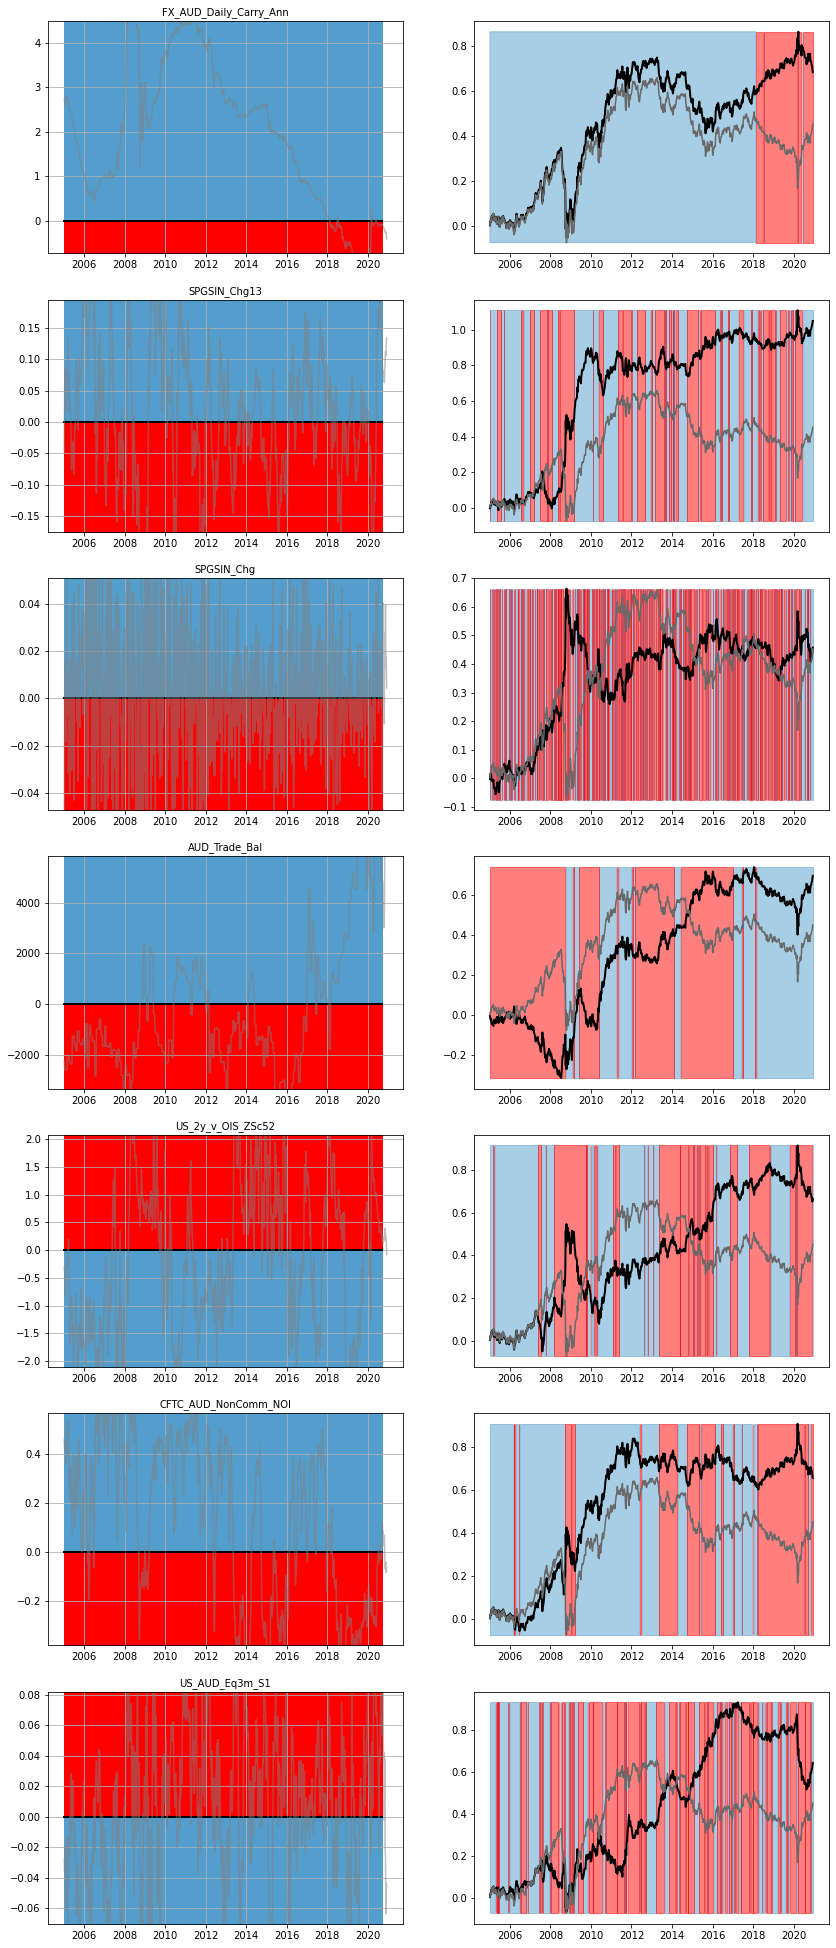

In [207]:
plot_substrat_thresholds(pnl, spec.substrats)

# Substrat Weighting

## Substrat Correlations

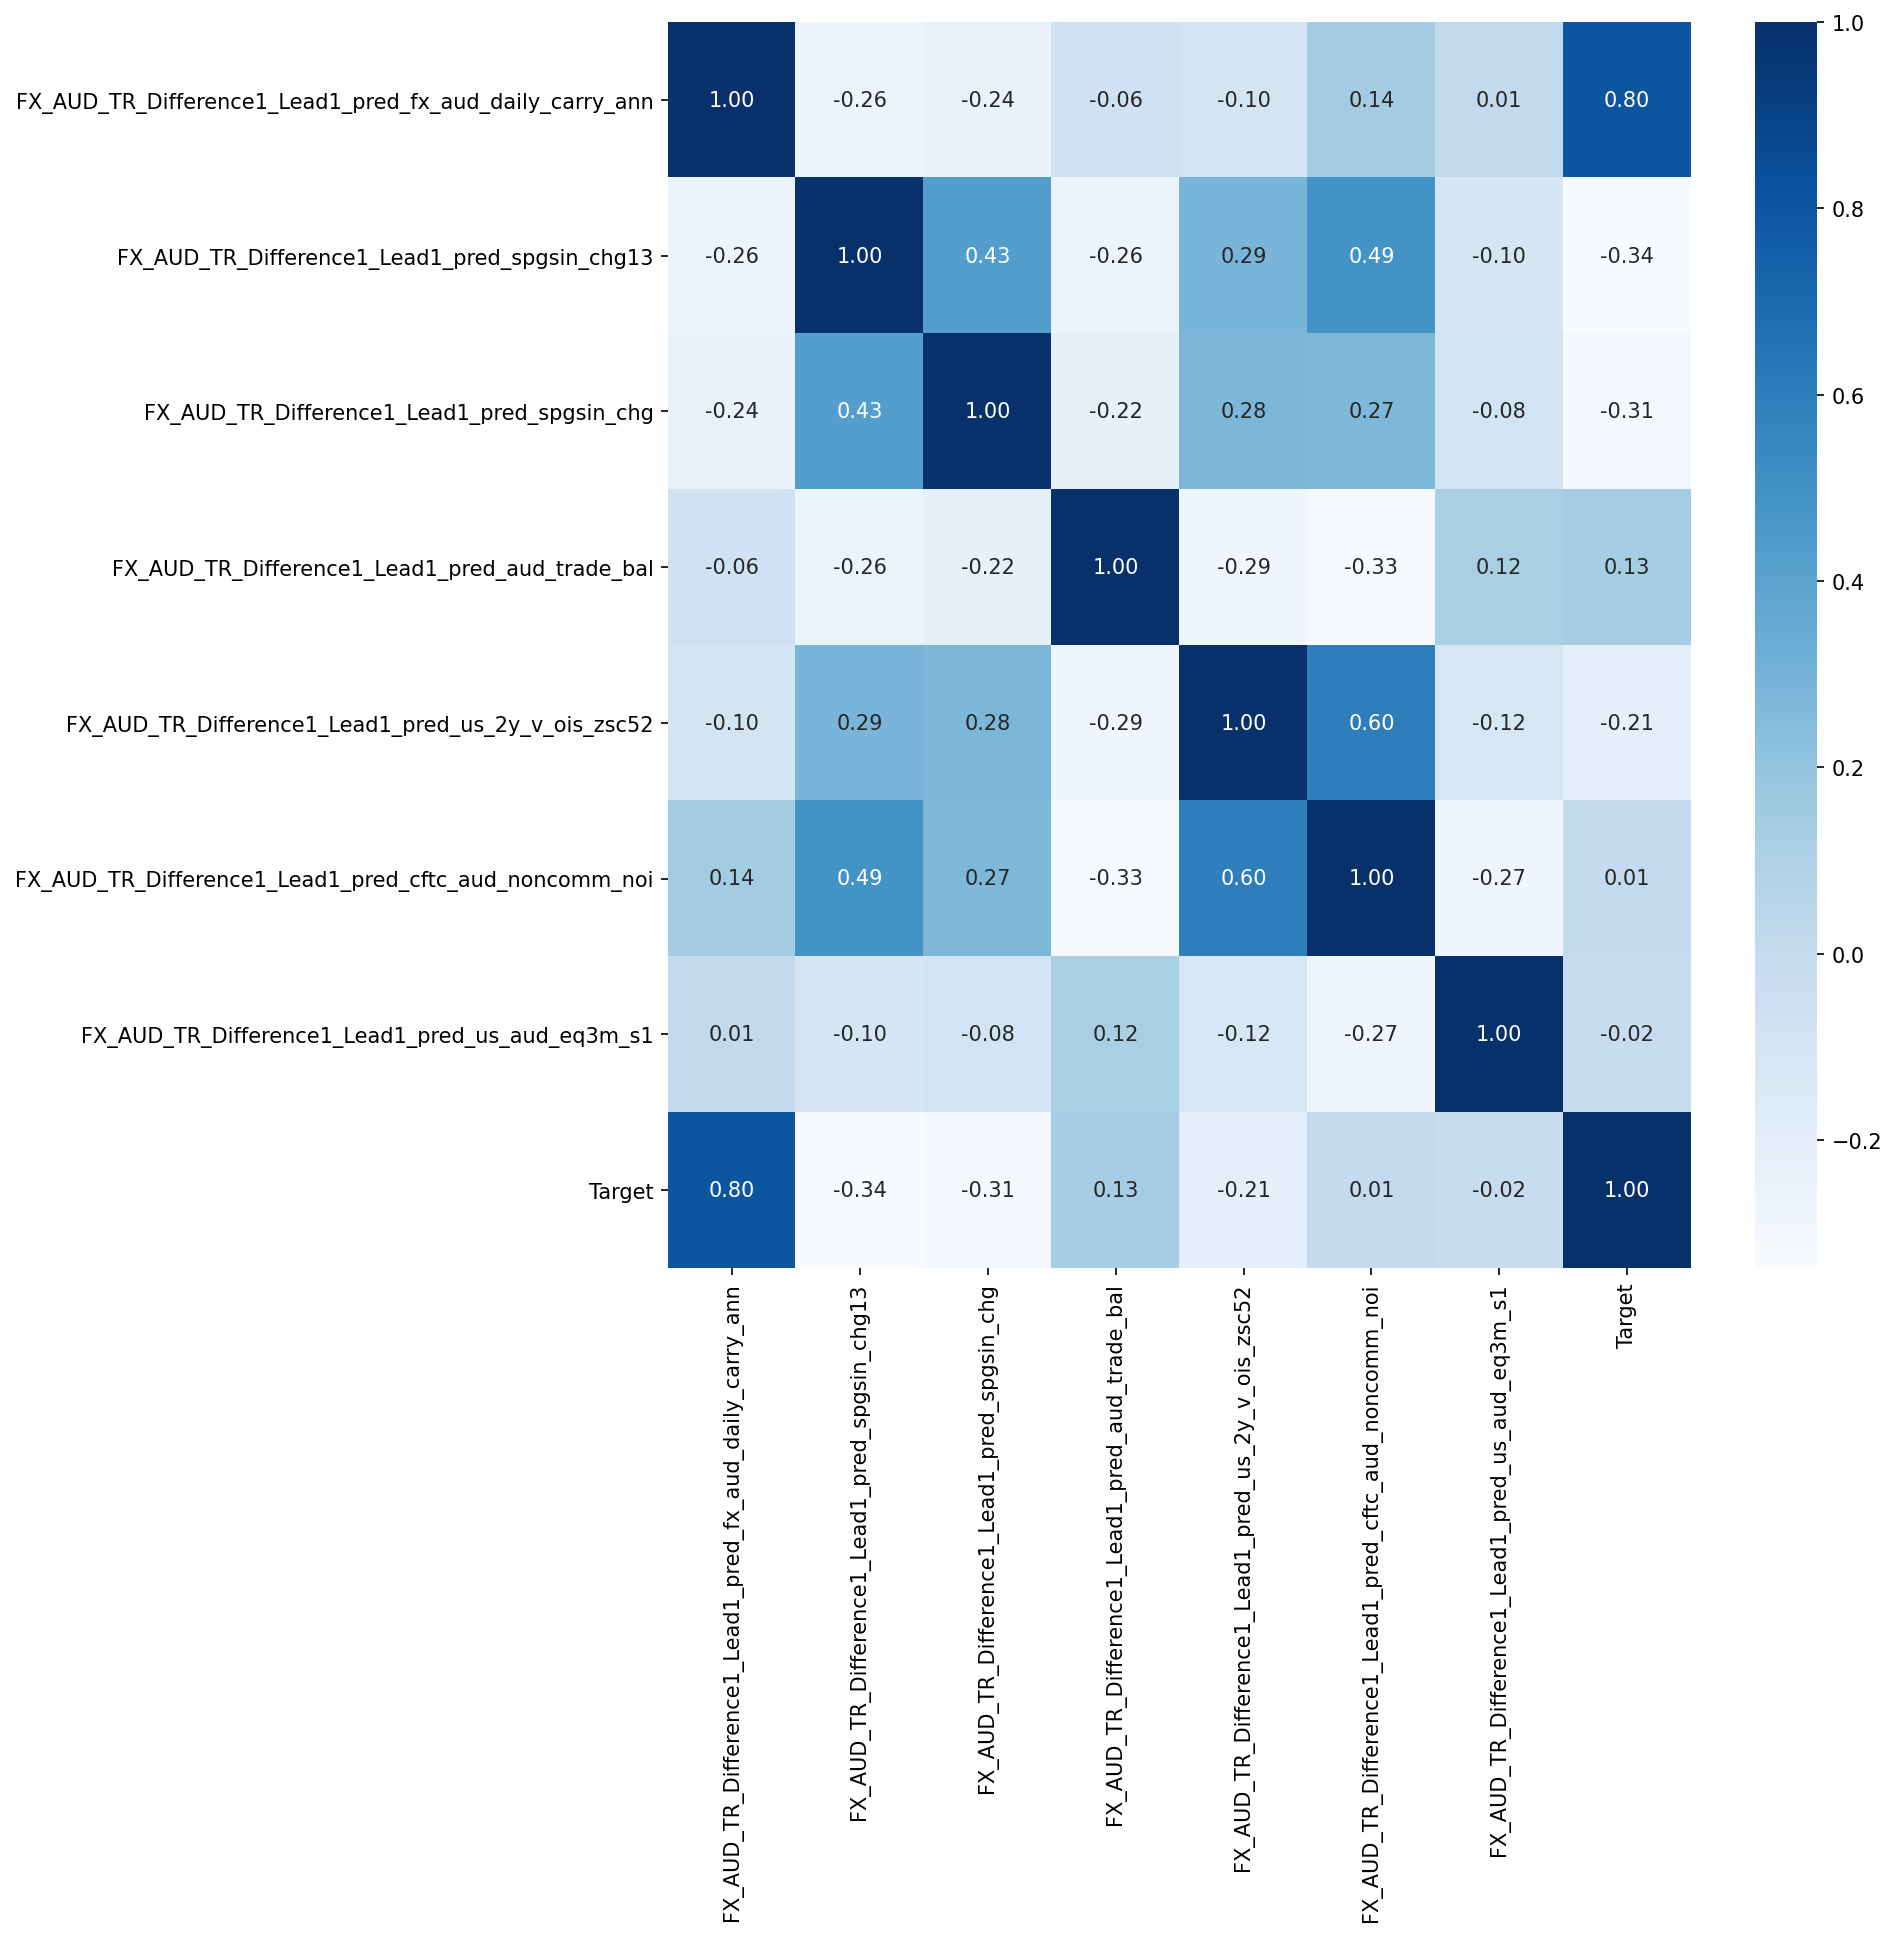

In [208]:
plot_substrat_correlation(pnl, signal=False, corr='pearson')

## Dendograms
Loop through windows and get strategy allocations

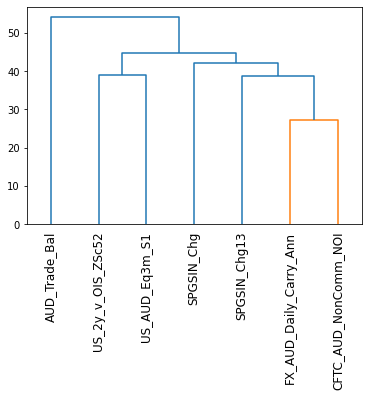

In [209]:
_ = dendo_window_iteration(pnl.signal.wf[-2], is_signal=spec.clustering.is_signal, corr=spec.clustering.corr, plot=True)

## Weighted Substrat Performance

<AxesSubplot:>

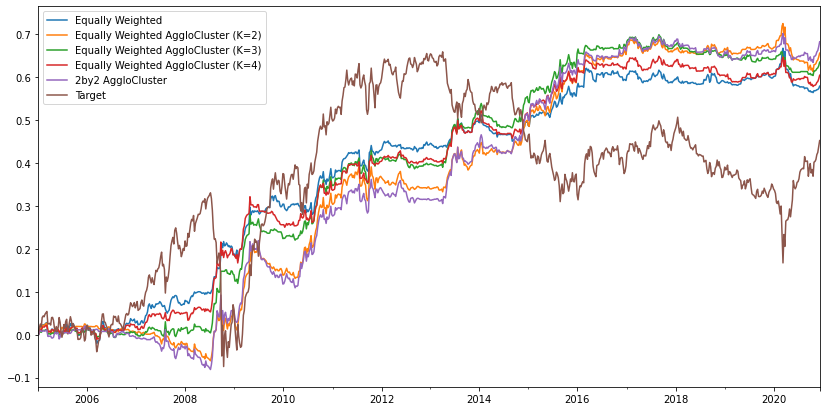

In [210]:
df_portfolios, weight_scheme_dict = weighted_substrat_performance(pnl.signal.wf, is_signal=spec.clustering.is_signal, corr=spec.clustering.corr, parallel=True)
df_portfolios.cumsum().plot(figsize=(14, 7))

## Strat Table Results

In [211]:
results = results_table(df_portfolios, signals=None, results_order=['Sharpe', 'Mean', 'Median', 'Vol', 'Max_Drawdown'])
results[['Mean', 'Median']] = results[['Mean', 'Median']]*52
results['Vol'] = results['Vol']*100
results

Sharpe      Mean        Median  \
Equally Weighted                     0.716110  3.618589  2.146027e+00   
Equally Weighted AggloCluster (K=2)  0.652702  4.099528  1.127570e-15   
Equally Weighted AggloCluster (K=3)  0.763433  3.968985  2.114194e-16   
Equally Weighted AggloCluster (K=4)  0.715921  3.777866  2.466560e-16   
2by2 AggloCluster                    0.655053  4.265470  0.000000e+00   
Target                               0.218193  2.826181  7.252512e+00   

                                           Vol  Max_Drawdown  
Equally Weighted                      5.053120     -0.103513  
Equally Weighted AggloCluster (K=2)   6.280856     -0.111951  
Equally Weighted AggloCluster (K=3)   5.198864     -0.095092  
Equally Weighted AggloCluster (K=4)   5.276931     -0.071092  
2by2 AggloCluster                     6.511644     -0.110060  
Target                               12.952678     -0.491877

## Equal Variance PL Charts

<AxesSubplot:title={'center':'Portfolio PL using target variance'}>

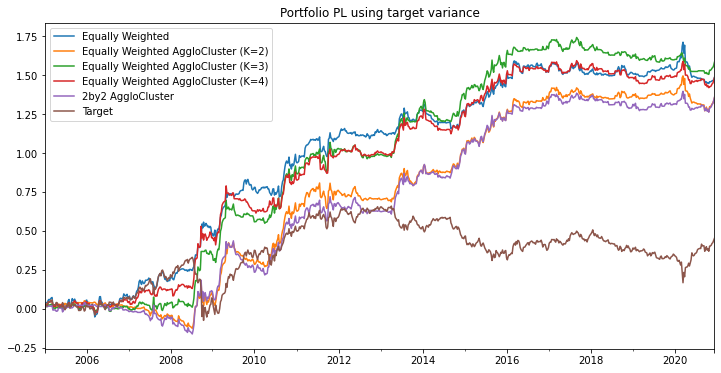

In [212]:
std = df_portfolios.std()
df_portfolios2 = df_portfolios*(std.loc['Target']/std)
df_portfolios2.cumsum().plot(figsize=(12, 6), title='Portfolio PL using target variance')

## Substrat Weighting Charts

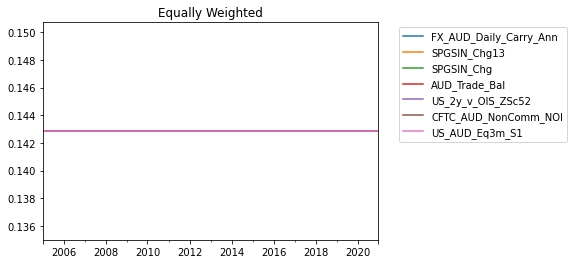

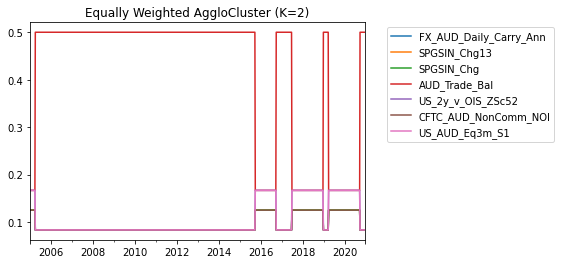

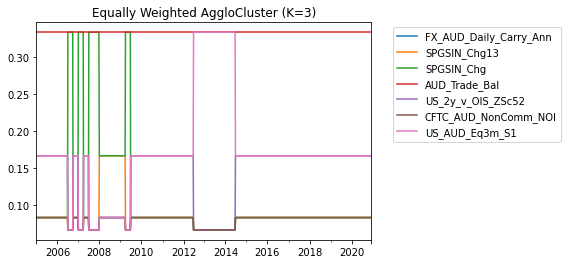

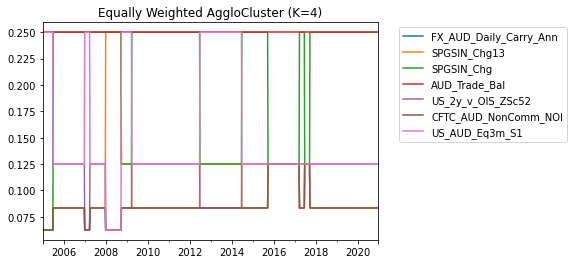

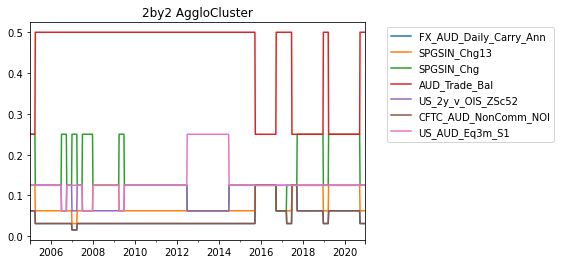

In [213]:
for name, weighting in weight_scheme_dict.items():
    weighting.plot(title=name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Effective Weights

In [214]:
df_signal = pnl.signal.get_signals().copy()
df_signal.columns = weight_scheme_dict['Equally Weighted'].columns

widgets.interactive(plot_signal_contribution, 
                    weight_scheme_dict=widgets.fixed(weight_scheme_dict), 
                    scheme=list(weight_scheme_dict.keys()), 
                    df_signal=widgets.fixed(df_signal))


interactive(children=(Dropdown(description='scheme', options=('Equally Weighted', 'Equally Weighted AggloClust…

# Feature Correlations

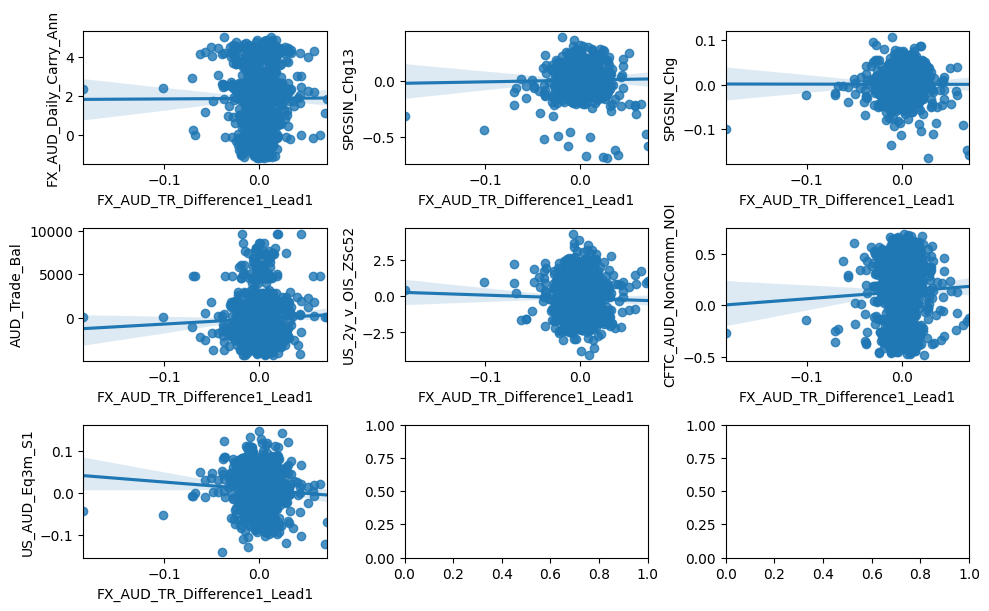

In [215]:
chart_feature_correlations(pnl, data, substrat_list=spec.substrats)